# Normal Sun Mode 2017:066 analysis #

### __Content__

* Study telemetry from two observations prior to the NSM transition:
    
    * ObsID = 50260
    
    * ObsID = 50259


* Gyro bias estimate in ObsID=50260.


* Star acquisition during the full field search at the start of the NSM transition, ObsID=50259.


* Attitude offset from the planned direction before NSM, ObsID=50259:
    1. Use the att. estimated at the time of full field search from the acquired stars.
    2. Find telemetry att. estimate (<code>aoattqt</code>) at that time, and at the time of the initial star acquisition.
    3. Derive dq between these two att. estimates.
    4. Apply dq to the att. estimated in (1) to derive the 'true' attitude of ObsID=50259.
    5. Compute offset from the planned attitude.

In [1]:
from kadi import events
nsun = events.normal_suns.filter(start='2017:065')[0]
time_nsm = nsun.start
print('Time of the 2017/066 Normal Sun Mode transition: {}'.format(time_nsm))

Time of the 2017/066 Normal Sun Mode transition: 2017:066:00:24:33.680


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from astropy.table import Table
import astropy.units as u
import Ska.engarchive.fetch as fetch
from Ska.Matplotlib import plot_cxctime
import Ska.engarchive.fetch as fetch
import Ska.arc5gl
from mica.archive import aca_l0, asp_l1
from Chandra.Time import DateTime
from chandra_aca.plot import plot_stars
from Quaternion import Quat
import agasc
import os
from itertools import cycle

In [3]:
def plot_att_changes(refs, atts, label):
    drs = []
    dps = []
    dys = []
    for ref_q, att_q in zip(cycle(refs['q_att']), atts['q_att']):
        dq = Quat(ref_q).dq(att_q)
        drs.append(dq.roll0 * 3600)
        dps.append(dq.pitch * 3600)
        dys.append(dq.yaw * 3600)

    plot_cxctime(obc_sol['time'], drs, '-b', label='Roll')
    plot_cxctime(obc_sol['time'], dps, '-g', label='Pitch')
    plot_cxctime(obc_sol['time'], dys, '-m', label='Yaw')
    plt.grid()
    plt.margins(0.05)
    plt.title('{}'.format(label))
    plt.ylabel('Change (arcsec)')
    plt.xlabel('Time')
    #plt.legend(loc='best');


def get_att_offset(quat, q_planned):
    dq = quat.dq(q_planned)

    print('d(Roll) = {:.1f} arcsec'.format(dq.roll0 * 3600))
    print('d(Pitch) = {:.1f} arcsec'.format(dq.pitch * 3600))
    print('d(Yaw) = {:.1f} arcsec'.format(dq.yaw * 3600))

    offset = agasc.agasc.sphere_dist(quat.ra, quat.dec,
                                     q_planned.ra, q_planned.dec)
    offset = (offset * u.deg).to('arcsec').value

    print('\nOffset = {:.1f} arcsec'.format(offset))
    
    return (dq.roll0 * 3600, dq.pitch * 3600, dq.yaw * 3600, offset)

In [4]:
keys = ['aoacmag', 'aoacyan', 'aoaczan']
slots = range(8)
msids_star = []
for slot in slots:
    msids = [key + np.str(slot) for key in keys]
    msids_star = msids_star + msids

### Maneuvers and ObsIDs prior to NSM ###

In [5]:
# https://icxc.cfa.harvard.edu/mp/mplogs/2017/MAR0617/oflsa/starcheck.html#obsid50260

obsids = [50260, 50259]

manvrs = events.manvrs.filter(start='2017:065:23:00:00.000',
                              stop='2017:066:00:30:00.000')

rows = []
for i, manvr in enumerate(manvrs):
    row = {'manvr': i + 1, 'start': manvr.start, 'stop': manvr.stop,
           'one_shot': manvr.one_shot, 'dur': manvr.dur,
           'tstart': manvr.tstart, 'tstop': manvr.tstop,
           'to_obsid': obsids[i]}
    rows.append(row)

tab = Table(rows,
            names=('manvr', 'start', 'stop', 'one_shot', 'tstart', 'tstop', 'dur', 'to_obsid'),
            dtype=('i2', 'S20', 'S20', 'f4', 'f8', 'f8', 'f4', 'i4'))
print(tab['manvr', 'start', 'stop', 'dur', 'one_shot', 'to_obsid'])

manvr        start                 stop           dur   one_shot to_obsid
----- -------------------- -------------------- ------- -------- --------
    1 2017:065:23:44:41.33 2017:065:23:48:41.18  239.85  6.28957    50260
    2 2017:065:23:54:39.93 2017:066:00:23:14.75 1714.83    -99.0    50259


### OBSID=50260 ###

### Offset from the planned attitude ###

In [6]:
# Starcheck, OBSID=50260
# MP_TARGQUAT at 2017:065:23:42:34.790 (VCDU count = 6623524)
# Q1,Q2,Q3,Q4: 0.08097196  -0.80871127  -0.40423026  0.41955635

q_planned = Quat([0.08097196, -0.80871127, -0.40423026, 0.41955635])

In [7]:
asol_file = 'pcadf605231539_asol1.fits'
grnd_sol = Table.read(asol_file)

In [8]:
obc_file = 'pcadf605231539_osol1.fits'
obc_sol = Table.read(obc_file)

In [9]:
# Check if the times match
grnd_sol2 = grnd_sol[::4]
np.max(obc_sol['time'] - grnd_sol2['time'])

0.0

In [10]:
print('Ground att. estimate, start of ObsID = 50260:\n')
q_ref = Quat(grnd_sol['q_att'][0])
result = get_att_offset(q_ref, q_planned)

print('\nGround att. estimate, end of ObsID = 50260:\n')
q_ref = Quat(grnd_sol['q_att'][-1])
result = get_att_offset(q_ref, q_planned)

Ground att. estimate, start of ObsID = 50260:

d(Roll) = -243.3 arcsec
d(Pitch) = 57.3 arcsec
d(Yaw) = -93.7 arcsec

Offset = 109.8 arcsec

Ground att. estimate, end of ObsID = 50260:

d(Roll) = -36.7 arcsec
d(Pitch) = 62.2 arcsec
d(Yaw) = -94.3 arcsec

Offset = 113.0 arcsec


In [11]:
print('OBC att. estimate, start of ObsID = 50260:\n')
q_ref = Quat(obc_sol['q_att'][0])
result = get_att_offset(q_ref, q_planned)

print('\nOBC att. estimate, end of ObsID = 50260:\n')
q_ref = Quat(obc_sol['q_att'][-1])
result = get_att_offset(q_ref, q_planned)

OBC att. estimate, start of ObsID = 50260:

d(Roll) = -243.2 arcsec
d(Pitch) = 57.4 arcsec
d(Yaw) = -93.7 arcsec

Offset = 109.9 arcsec

OBC att. estimate, end of ObsID = 50260:

d(Roll) = -197.9 arcsec
d(Pitch) = 62.2 arcsec
d(Yaw) = -94.0 arcsec

Offset = 112.7 arcsec


### Gyro bias analysis ###

In [12]:
msids_gb = ['aogbias1', 'aogbias2', 'aogbias3']
axes = ['Roll', 'Pitch', 'Yaw']
colors = 'bgm'

In [13]:
start = grnd_sol2['time'][0]
stop = grnd_sol2['time'][-1]
telem_gb = fetch.MSIDset(msids_gb, start=start, stop=stop)


ObsID=50260 (before manvr. prior to NSM)


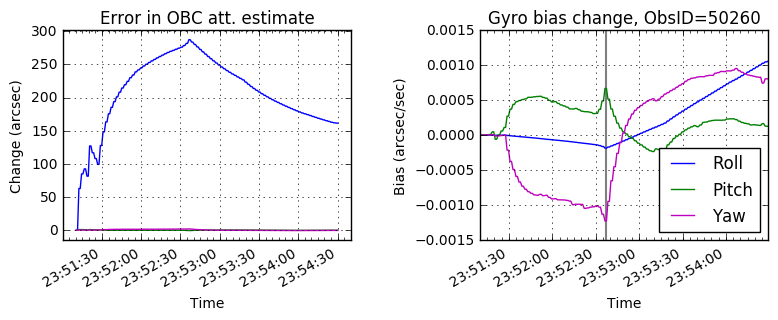

In [14]:
print('\nObsID=50260 (before manvr. prior to NSM)')

plt.figure(figsize=(7.5, 3))

plt.subplot(1, 2, 1)

label = 'Error in OBC att. estimate'
plot_att_changes(refs=grnd_sol2, atts=obc_sol, label=label)

plt.subplot(1, 2, 2)

colors = 'bgm'
for i, msid in enumerate(msids_gb):
    plot_cxctime(telem_gb[msid].times,
                 ((telem_gb[msid].vals - telem_gb[msid].vals[0]) * u.radian / u.s).to('arcsec/s'),
                 color=colors[i], label=axes[i])

plt.ylabel('Bias (arcsec/sec)')
plt.xlabel('Time')
plt.title('Gyro bias change, ObsID=50260')
plt.legend(loc='best')
plt.grid();

# Mark time of the one shot update
plt.vlines([DateTime('2017:065:23:52:37').plotdate], plt.ylim()[0], plt.ylim()[1],
           color='gray', linestyle='solid', lw=1.5)

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.45)


ObsID=50260 (before manvr. prior to NSM)


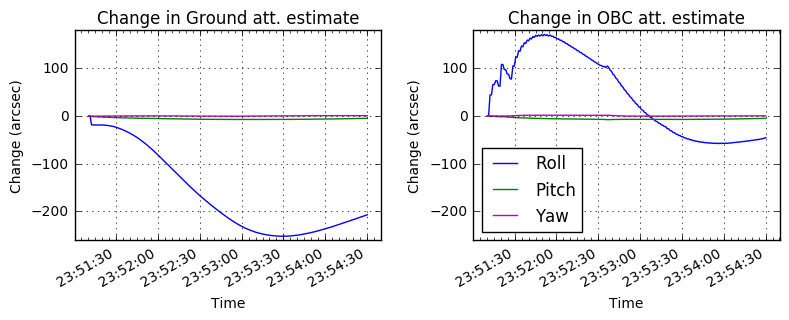

In [15]:
print('\nObsID=50260 (before manvr. prior to NSM)')

plt.figure(figsize=(7.5, 3))

plt.subplot(1, 2, 1)

label = 'Change in Ground att. estimate'
plot_att_changes(refs=grnd_sol2[:1], atts=grnd_sol2, label=label)
plt.ylim(-260, 180)

plt.subplot(1, 2, 2)

label = 'Change in OBC att. estimate'
plot_att_changes(refs=grnd_sol2[:1], atts=obc_sol, label=label)
plt.ylim(-260, 180)
plt.legend(loc='best')

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.3)

In [16]:
# Fetch aoacmag, aoacyan, aoaczan telemetry
start = tab['tstart'][0]
stop = tab['tstop'][1] - 1400
telem = fetch.MSIDset(msids_star, start=start, stop=stop)

In [17]:
# Define reference times for average mag, yan, zan calculations
start_av = tab['tstop'][0] + 180
stop_av = tab['tstart'][1] - 5

times = [[start_av, stop_av]] * 6
times.insert(4, [start_av - 5, stop_av - 125])
times.append([start_av + 95, stop_av])

In [18]:
rows = []
row = {}

for idx, msid in enumerate(msids_star):
    # Average mag, yan, zan
    t1, t2 = times[idx // 3]
    times_mean = (telem[msid].times > t1) & (telem[msid].times < t2)
    average = telem[msid].vals[times_mean].mean()
    row[msid[:-1]] = average    
    if np.mod(idx, 3) == 2:
        row['slot'] = idx // 3
        rows.append(row)
        row = {}

In [19]:
t_50260 = Table(rows)

cols = t_50260.colnames
cols.remove('slot')

for col in cols:
    t_50260[col].format = '%.3f'

White: ObsID 50260
Gray: Maneuvers


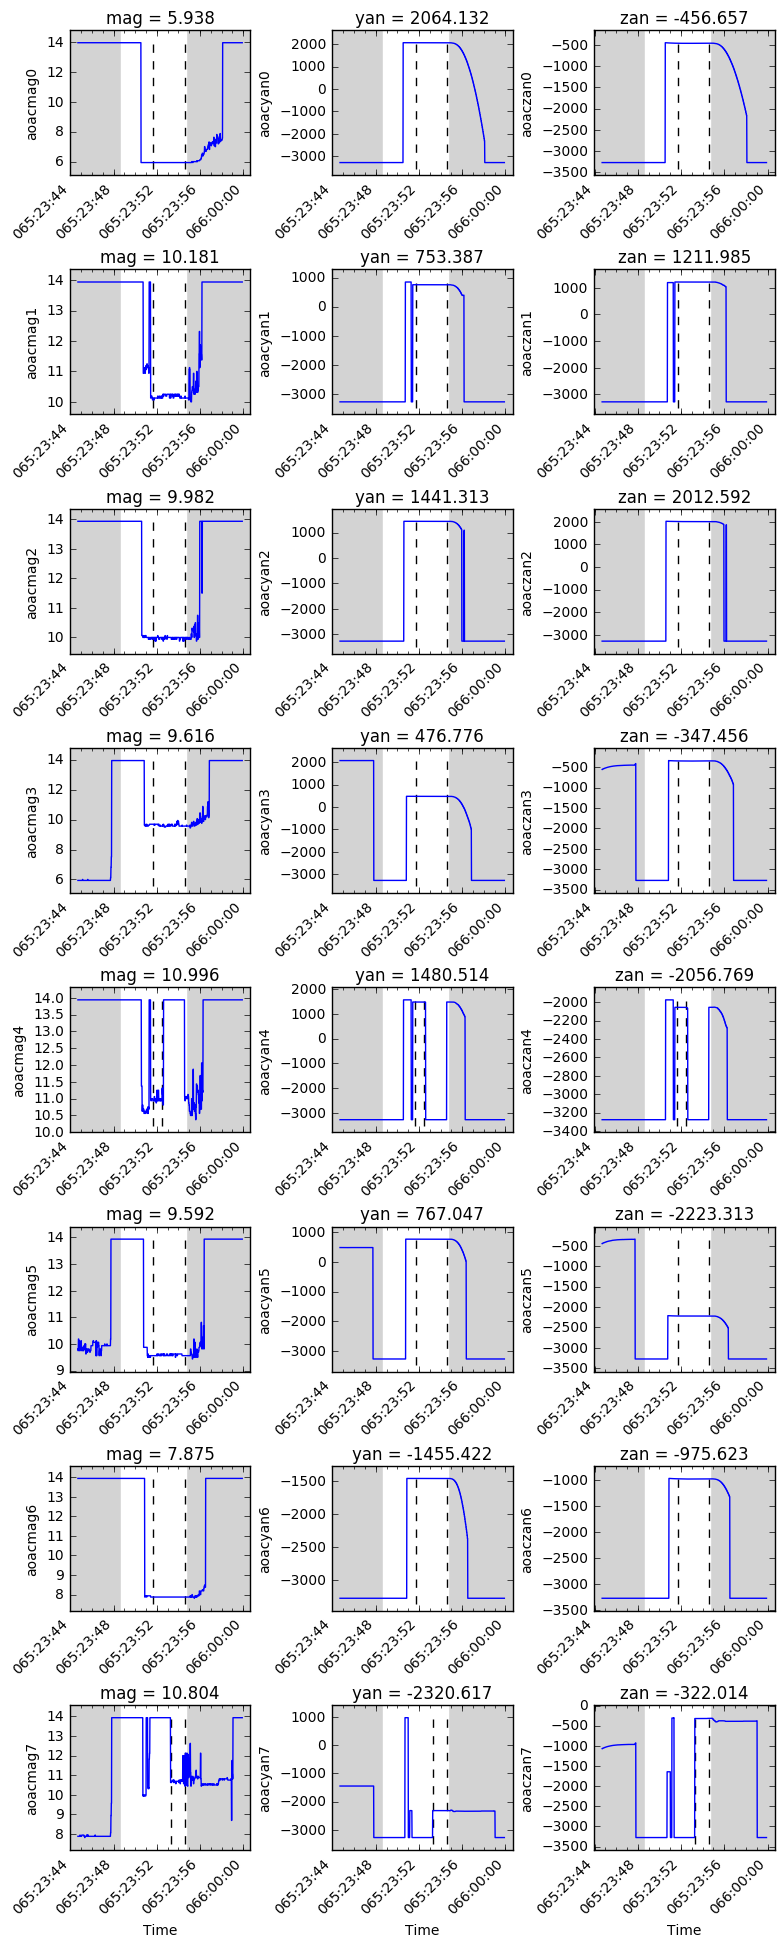

In [20]:
plt.figure(figsize=(7.5, 26))

for idx, msid in enumerate(msids_star):
    # Plot
    plt.subplot(8, 3, idx + 1, axisbg='lightgray')
    plot_cxctime(telem[msid].times, telem[msid].vals)
    plt.ylabel(msid)
    plt.xlabel("Time")
    plt.margins(0.05)  
    
    label = t_50260[msid[:-1]][idx // 3]
    plt.title('{} = {:.3f}'.format(msid[4:7], label))
    
# Mark obsid time span (white) and reference times (dashed lines)
start_50260 = DateTime(tab['tstop'][0]).plotdate
stop_50260 = DateTime(tab['tstart'][1]).plotdate

for idx, ax in enumerate(plt.gcf().axes):
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha='right')
    ax.axvspan(start_50260, stop_50260, ymin=-5000, ymax=5000, color='white')
    av_times = DateTime(times[idx // 3]).plotdate
    ax.vlines(av_times, ax.get_ylim()[0], ax.get_ylim()[1], color='k', linestyle='--')
        
plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.45, hspace=0.65)

print('White: ObsID 50260')
print('Gray: Maneuvers')

In [21]:
print(t_50260['slot', 'aoacyan', 'aoaczan', 'aoacmag'])

slot  aoacyan   aoaczan  aoacmag
---- --------- --------- -------
   0  2064.132  -456.657   5.938
   1   753.387  1211.985  10.181
   2  1441.313  2012.592   9.982
   3   476.776  -347.456   9.616
   4  1480.514 -2056.769  10.996
   5   767.047 -2223.313   9.592
   6 -1455.422  -975.623   7.875
   7 -2320.617  -322.014  10.804


In [22]:
# Kadi, attitude solution:
#
# Attitude solution
# Coordinates
#
# RA=216.520438558
# Dec=37.8175070267
# Roll=113.94881085
#
# Q1=0.0808060412669
# Q2=-0.808580451772
# Q3=-0.404505006298
# Q4=0.419575662528
#
#  
# Star match summary and residuals 
#
# slot    YAG       ZAG    MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id
# ---- --------- --------- ------- -------- ----- -------- ----- ---- ----------
#   0  2064.132  -456.657   5.938  2064.14 -0.01  -457.00  0.34 0.34  397805704
#   2  1441.313  2012.592   9.982  1441.34 -0.03  2013.30 -0.71 0.71  397807608
#   3   476.776  -347.456   9.616   476.77  0.01  -347.63  0.17 0.17  397808560
#   5   767.047 -2223.313   9.592   767.44 -0.39 -2223.73  0.42 0.57  397940208
#   6 -1455.422  -975.623   7.875 -1455.85  0.42  -975.40 -0.22 0.48  397943760

q_kadi = Quat([0.0808060412669, -0.808580451772, -0.404505006298, 0.419575662528])

result = get_att_offset(q_kadi, q_planned)

d(Roll) = 142.8 arcsec
d(Pitch) = 7.8 arcsec
d(Yaw) = -6.6 arcsec

Offset = 10.2 arcsec


### OBSID=50259 ###

In [23]:
# Fetch aoacmag, aoacyan, aoaczan telemetry
start = tab['tstop'][1]
stop = '2017:066:00:28:00'
telem = fetch.MSIDset(msids_star, start=start, stop=stop)

In [24]:
# Define reference times
tstart_acq = DateTime('2017:066:00:24:05.000').secs
tstop_acq = DateTime('2017:066:00:24:20.000').secs

times_acq = [tstart_acq, tstop_acq]
times_av = (telem['aoacmag0'].times > times_acq[0]) & (telem['aoacmag0'].times < times_acq[1])

time_ffs = DateTime('2017:066:00:25:33.000').secs
ok = (np.abs(telem['aoacmag0'].times - time_ffs)).argmin()

In [25]:
rows = []
row = {}

for idx, msid in enumerate(msids_star):
    # Average mag, yan, zan and telem at idx=ok (full field search)
    average = telem[msid].vals[times_av].mean()
    row[msid[:-1]] = average    
    row[msid[:-1] + '_ffs'] = telem[msid].vals[ok]
    if np.mod(idx, 3) == 2:
        row['slot'] = idx // 3
        rows.append(row)
        row = {}

In [26]:
t = Table(rows)

cols = t.colnames
cols.remove('slot')

for col in cols:
    t[col].format = '%.3f'

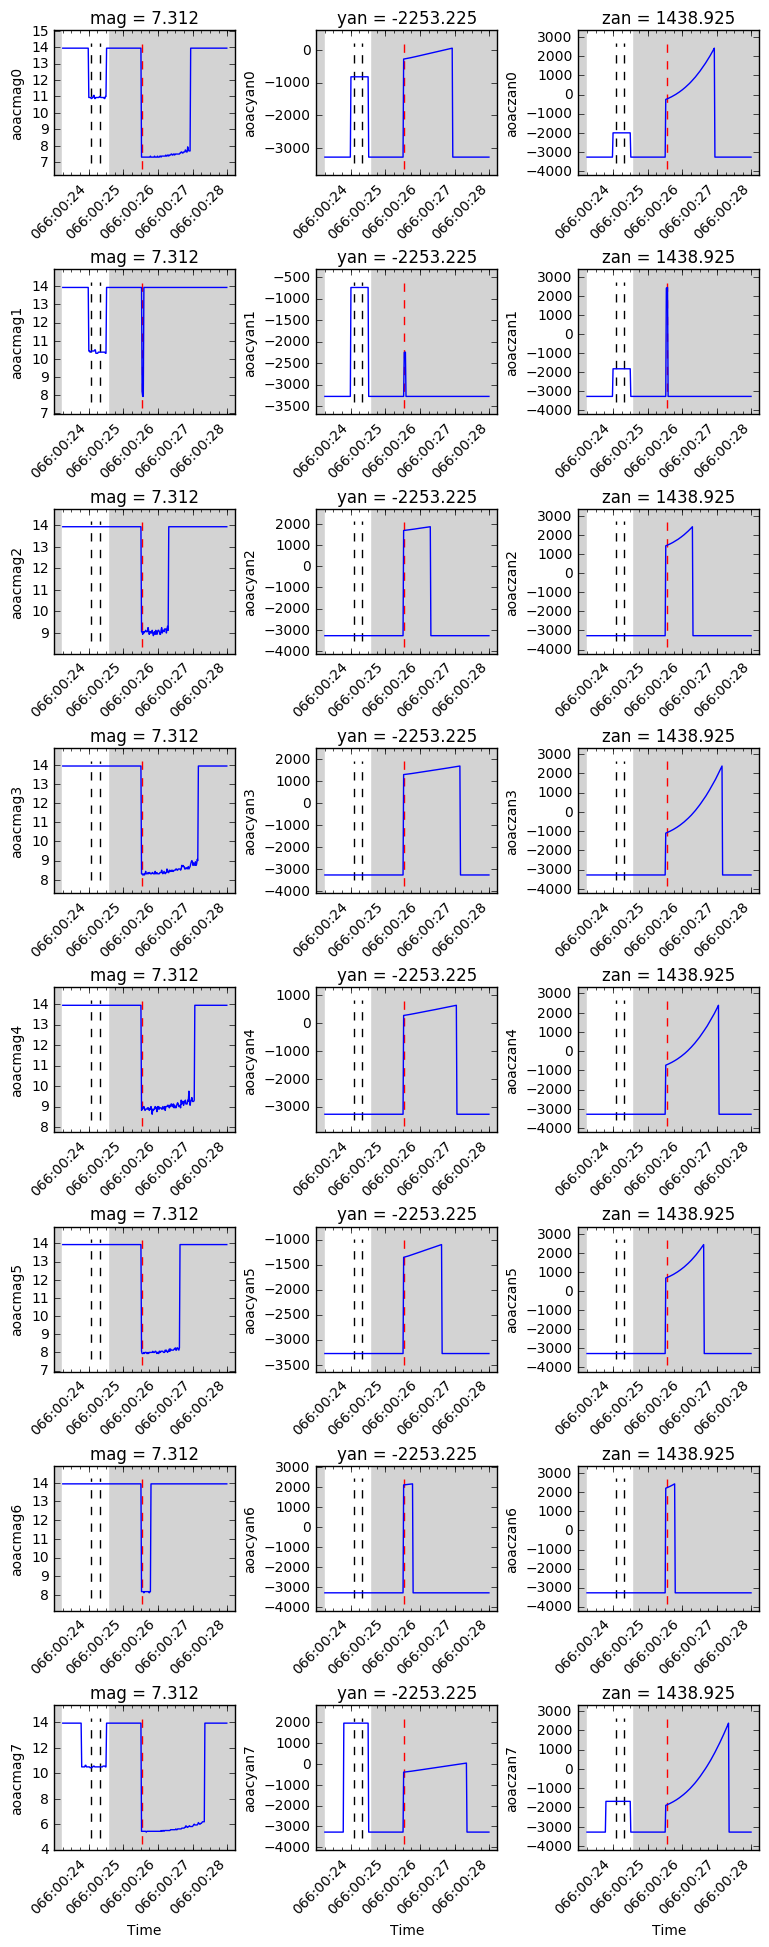

In [27]:
plt.figure(figsize=(7.5, 26))

for idx, msid in enumerate(msids_star):
    # Plot
    plt.subplot(8, 3, idx + 1, axisbg='lightgray')
    plot_cxctime(telem[msid].times, telem[msid].vals)
    label = t[msid[:-1] + '_ffs'][np.mod(idx, 3)]
    plt.title('{} = {:.3f}'.format(msid[4:7], label))
    plt.ylabel(msid)
    plt.xlabel("Time")
    plt.margins(0.05)

# Mark obsid time span (white) and reference times (dashed lines)
start_50259 = DateTime(start).plotdate
stop_50259 = DateTime(time_nsm).plotdate

for idx, ax in enumerate(plt.gcf().axes):
    plt.setp(ax.get_xticklabels(), visible=True, rotation=45, ha='right')
    ax.axvspan(start_50259, stop_50259, ymin=-5000, ymax=5000, color='white')
    ax.vlines(DateTime(times_acq).plotdate, ax.get_ylim()[0], ax.get_ylim()[1],
              color='k', linestyle='dashed')
    ax.vlines([DateTime(time_ffs).plotdate], ax.get_ylim()[0], ax.get_ylim()[1],
              color='red', linestyle='dashed')

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, wspace=0.45, hspace=0.65)

__Images acquired at <code>2017:066:00:24:30</code> (black dashed lines), approximately 3 sec prior to the NSM transition:__

<img style="float: left;" src='aca-movie-2017-066-00-24-30.png' width='750'>

In [28]:
ok = t['aoacmag'] < 13
print(t['slot', 'aoacyan', 'aoaczan', 'aoacmag'][ok])

slot aoacyan   aoaczan  aoacmag
---- -------- --------- -------
   0 -824.562 -2005.043  10.950
   1 -741.210 -1822.615  10.396
   7 1956.518 -1684.533  10.504


In [29]:
print(t['slot', 'aoacyan_ffs', 'aoaczan_ffs', 'aoacmag_ffs'])

slot aoacyan_ffs aoaczan_ffs aoacmag_ffs
---- ----------- ----------- -----------
   0    -279.875    -243.100       7.312
   1   -2253.225    2431.250       8.188
   2    1691.400    1438.925       9.062
   3    1304.950   -1092.900       8.312
   4     274.950    -715.550       8.875
   5   -1351.175     699.525       7.938
   6    2103.875    2234.775       8.188
   7    -394.325   -1879.650       5.438


In [30]:
# Kadi, find_attitude
#
# Attitude solution
# Coordinates
#
# RA=150.496217865
# Dec=31.4310743185
# Roll=214.93547334
#
# Q1=-0.155187853786
# Q2=-0.908663993779
# Q3=0.21363345805
# Q4=0.323430397532
#
#  
# Star match summary and residuals 
#
# slot    YAG      ZAG    MAG_ACA  m_yag     dy   m_zag     dz   dr  m_agasc_id    50259_catalog_slot
# ---- --------- -------- ------- -------- ----- -------- ----- ---- ----------
#   0  -279.875   -243.1   7.312  -280.05  0.18  -243.13  0.03 0.18  328081352     5
#   1 -2253.225  2431.25   8.188       --    --       --    --   --         --     --
#   2    1691.4 1438.925   9.062  1691.98 -0.58  1438.67  0.26 0.64  328078016     2
#   3   1304.95  -1092.9   8.312  1305.04 -0.09 -1093.13  0.23 0.24  327951064     ???
#   4    274.95  -715.55   8.875   275.27 -0.32  -714.81 -0.74 0.80  328081440     6
#   5 -1351.175  699.525   7.938 -1351.26  0.09   699.54 -0.02 0.09  328078824     3
#   6  2103.875 2234.775   8.188  2103.18  0.69  2234.56  0.21 0.72  328081232     4
#   7  -394.325 -1879.65   5.438  -394.36  0.04 -1879.67  0.02 0.04  328085344     ???

q_kadi = Quat([-0.155187853786, -0.908663993779, 0.21363345805, 0.323430397532])

# OBSID = 50259
# MP_TARGQUAT at 2017:065:23:54:34.470 (VCDU count = 6626333)
#  Q1,Q2,Q3,Q4: -0.15519481  -0.90893399  0.21402725  0.32240644
q_planned = Quat([-0.15519481, -0.90893399, 0.21402725, 0.32240644])

result = get_att_offset(q_kadi, q_planned)

d(Roll) = 57.2 arcsec
d(Pitch) = -444.5 arcsec
d(Yaw) = 128.0 arcsec

Offset = 462.5 arcsec


In [31]:
# Find times of AQXN

start = tab['tstop'][1]
stop = time_ffs + 10

telem = fetch.MSID('aoacaseq'.format(i), start=start, stop=stop)

ifirst = list(telem.vals).index('AQXN')
ilast = len(telem.vals) - 1 - list(telem.vals[::-1]).index('AQXN')

ok = (np.abs(telem.times - time_ffs)).argmin()
ibrit = list(telem.vals).index('BRIT')

tstart_aqxn = telem.times[ifirst]
tstop_aqxn = telem.times[ilast]
tffs = telem.times[ok]

# Find quaternions corresponding to start/stop AQXN times and time of FFS

msids_quat = ['aoattqt1', 'aoattqt2', 'aoattqt3', 'aoattqt4']
telem_quat = fetch.MSIDset(msids_quat, start=start, stop=stop)

ok = []
for tt in [tstart_aqxn, tstop_aqxn, tffs]:
    ok.append((np.abs(telem_quat['aoattqt1'].times - tt)).argmin())
    
quats = []
for i in ok:
    q = []
    for msid in msids_quat:
        q.append(telem_quat[msid].vals[i])
    quats.append(q)

quats = [Quat(q) for q in quats]

# Maneuver from est. att. at FFS to est. att. at start of AQXN
dq = quats[2].dq(quats[0])

# Apply this maneuver to att. found with kadi (at FFS) to get 'true' att. the time of AQXN
q_true = q_kadi * dq

# Find attitude offset from the planned direction

result = get_att_offset(q_true, q_planned)

d(Roll) = 87.1 arcsec
d(Pitch) = -134.7 arcsec
d(Yaw) = 48.8 arcsec

Offset = 143.3 arcsec
